In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import urllib.request

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM,
                                    GRU,
                                    Embedding,
                                    BatchNormalization,
                                    Dense,
                                    TimeDistributed,
                                    Dropout,
                                    Bidirectional,
                                    Flatten,
                                    GlobalMaxPool1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from operator import itemgetter
import string
from tqdm import tqdm
import re

In [2]:
from nltk import download
from nltk.corpus import stopwords
download('stopwords')
download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\windo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\windo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Classifying tweets as disaster related using Recurrent Nueral Networks and Natural Language Processing

This project will be broken up into the following sections:

1. Problem Exploration and Description of Data
2. Exploratory Data Analysis and Data Cleaning
3. Initial Model Architecture
4. Analysis of Initial Architecture
5. Alternate Architecture and Hyper Parameter Tuning
6. Conclusion

## Problem Exploration and Description of Data

In [3]:
df = pd.read_csv("nlp-getting-started\\train.csv")
test = pd.read_csv("nlp-getting-started\\test.csv")

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.iloc[199]

id                                                        280
keyword                                             ambulance
location                                               Canada
text        ÛÏ@LeoBlakeCarter: This dog thinks he's an am...
target                                                      0
Name: 199, dtype: object

From each row we have 1 index value, 3 values of interest, and a target value. The 3 values of interest include a keyword, location, and the text body of the tweet.

In [6]:
print(f"There are {df.shape[0]} training tweets and {test.shape[0]} testing tweets.")

There are 7613 training tweets and 3263 testing tweets.


## Exploratory Data Analysis and Data Cleaning

0    4342
1    3271
Name: target, dtype: int64


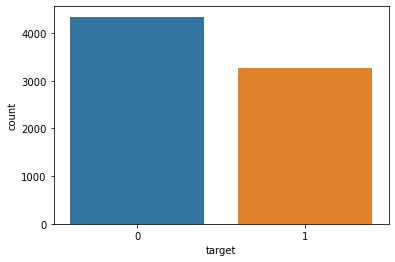

In [7]:
counts = df["target"].value_counts()
sns.countplot(x = 'target', data = df)
print(counts)

In [8]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

We see that the location is missing for approximately 33% of the tweets, keyword is missing in less than 1% of tweets.

<AxesSubplot:xlabel='word_len', ylabel='Density'>

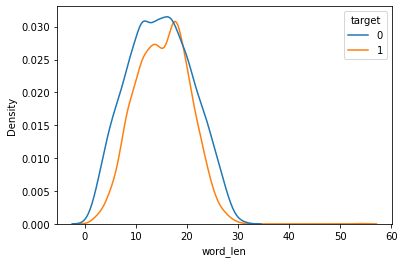

In [9]:
df['word_len'] = df['text'].str.split(' ').apply(len)
df['char_len'] = df['text'].apply(len)
sns.kdeplot(x = 'word_len', data = df, hue = 'target')

Here we can see that the length of the tweet may have some effect on classifying the tween as a disaster or non disaster. But the majority of tweets in both categories fall in the normal distribution range.

In [10]:
# Create list with every word from tweets in disaster group and non disaster group
def word_list(dataset, truth_value):
    '''
    Return a list that contains every word in every tweet that has the same target value as the truth_value param
    '''
    l = []
    for split_tweet in dataset.loc[dataset['target'] == truth_value, 'text'].str.split():
        for word in split_tweet:
            l.append(word)
    return l

disaster_word_list = word_list(df, 1)
non_disaster_word_list = word_list(df, 0)

In [11]:
def word_list_to_dict(word_list):
    count_dict = {}
    for word in word_list:
        if word in count_dict:
            count_dict[word] += 1
        else:
            count_dict[word] = 1
    return count_dict

disaster_count_dict = word_list_to_dict(disaster_word_list)
non_disaster_count_dict = word_list_to_dict(non_disaster_word_list)


In [12]:
def top_x_from_dict(count_dict, x):
    return sorted(count_dict.items(), key = itemgetter(1), reverse = True)[:x]

In [13]:
top_disaster = top_x_from_dict(disaster_count_dict, 25)
top_non_disaster = top_x_from_dict(non_disaster_count_dict, 25)

In [14]:
print(f"In disaster tweets the top {len(top_disaster)} words are as follows:")
for i in range(len(top_disaster)):
    print(f"{i + 1} : {top_disaster[i]}")

In disaster tweets the top 25 words are as follows:
1 : ('the', 1051)
2 : ('in', 1037)
3 : ('of', 888)
4 : ('a', 730)
5 : ('to', 706)
6 : ('and', 462)
7 : ('-', 389)
8 : ('on', 386)
9 : ('for', 368)
10 : ('is', 302)
11 : ('at', 273)
12 : ('I', 259)
13 : ('The', 257)
14 : ('by', 244)
15 : ('from', 206)
16 : ('A', 167)
17 : ('that', 166)
18 : ('with', 159)
19 : ('was', 158)
20 : ('are', 150)
21 : ('it', 143)
22 : ('after', 140)
23 : ('as', 139)
24 : ('have', 134)
25 : ('via', 115)


In [15]:
print(f"In disaster tweets the top {len(top_non_disaster)} words are as follows:")
for i in range(len(top_non_disaster)):
    print(f"{i + 1} : {top_non_disaster[i]}")

In disaster tweets the top 25 words are as follows:
1 : ('the', 1524)
2 : ('a', 1115)
3 : ('to', 1099)
4 : ('I', 938)
5 : ('and', 840)
6 : ('of', 834)
7 : ('in', 720)
8 : ('you', 529)
9 : ('is', 512)
10 : ('for', 452)
11 : ('my', 442)
12 : ('on', 387)
13 : ('-', 374)
14 : ('with', 349)
15 : ('that', 326)
16 : ('The', 295)
17 : ('it', 290)
18 : ('be', 268)
19 : ('like', 233)
20 : ('this', 225)
21 : ('by', 225)
22 : ('have', 219)
23 : ('at', 212)
24 : ('was', 205)
25 : ('your', 201)


For both disaster and non-disaster portions of the dataset the top words are "function" words, which can carry meaning in a communicative context, but we will interfere with our models ability to asses tweets. Thus one element of our data cleaning will be removing these words from the tweets. In the natural language processing world, these words are often reffered to as stop words.

In this same mode of thinking we need to remove punctuation from all of these tweets and change all of the tweets to lower case as this can cause issues with the vectorization of tweets.

In [16]:
#Remove punctuation and change all tweets to lower case
def punctuation_lower(in_string):
    in_string = in_string.lower()
    in_string = in_string.translate(str.maketrans('', '', string.punctuation))
    return in_string

In [17]:
punctuation_lower("HELLO! YOuRE t*/?he BEst!")

'hello youre the best'

In [18]:
print(len(df['text']))

7613


In [97]:
# The clean text and remove emoji functions were borrowed from this notebook:
# https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook#Model
# I'm not great with regular expressions, nor do I have much NLP experience so this was something that I
# probably could not have accomplished on my own.

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['text'] = df['text'].apply(lambda x: clean_text(x))


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

def remove_stop_words(text):
    stop_words_list = stopwords.words('english')
    text = ' '.join(word for word in text.split(' ') if word not in stop_words_list)
    return text

df['text'] = df['text'].apply(lambda x: remove_stop_words(x))

df['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3     people receive wildfires evacuation orders ca...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [98]:
texts = df.text.values
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)
len_vocab = len(word_tokenizer.word_index) + 1

In [99]:
print(len_vocab)

16701


In [100]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

In [101]:
# Padding tweets
longest_tweet = max(texts, key = lambda sentence: len(word_tokenize(sentence)))
print(longest_tweet)
length_longest_tweet = len(word_tokenize(longest_tweet))
padded_sentences = pad_sequences(embed(texts), length_longest_tweet, padding ='post')
print(padded_sentences[0])

rite man tlk widout nuh curfew long side aka cum fi steal di show itz rubbery di whole dem fi knw sound music
[4165  723  142   53 1512 4166   12    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


The longest tweet printed above illuminates a difficult issue beyond the scope of this assignment, lexically speaking the vernacular used here will not be captured by the embedding. So we are going to be unable to properly classify this tweet.

In [102]:
#Glove
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open(".\\glove.6B\\glove.6B.100d.txt", 'r', encoding = 'utf8')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [103]:
#Embedding Matrix
embedding_matrix = np.zeros((len_vocab, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(16701, 100)


In [104]:
X_train, X_val, y_train, y_val = train_test_split(
    padded_sentences,
    df["target"].values,
    test_size = 0.25,
    random_state = 789
)

In [105]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))

5709 5709
1904 1904


## Initial Model Architecture

The first rendition of our model architecture incorporates only basic elements to get the model off the ground and working. We have an embedding layer that handles our Glove embedding, a bidirectional GRU layer, a hidden dense layer, and our output layer.

The GRU layer was chosen over the LSTM layer because the length of the datasets aren't incredibly long, and in light of this being our first rendition, speed is of more concern than accuracy. Also our dataset is very small, which favors the GRU cell.

Bidirectionality was chosen for the GRU layer because the lexical meaning of words exists in a bidirectional manner. A word after another word can change the meaning of the first word, thus we want to be considering the implications of interactions in both directions.

Finally we have chosen the adam optimizer and binary_crossentropy as our loss function. Binary crossentropy was chosen because we are classifying into a binary final form, and Adam optimization was chosen for it's generally high performance in a wide variety of applications. Of these two switching from Adam to an optimizer with better sequence analysis capabilities will most likely yield better results.

In [106]:
def model_1():
    model = Sequential()
    
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = length_longest_tweet
    ))
    
#    model.add(Bidirectional(LSTM(
#        length_longest_tweet,
#        return_sequences = True,
#        recurrent_dropout = 0.2
#    )))
    
    model.add(Bidirectional(GRU(
        length_longest_tweet,
        return_sequences = True,
        recurrent_dropout = 0.2
    )))
    
    model.add(Dense(length_longest_tweet, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

model1 = model_1()
model1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 23, 100)           1670100   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 23, 46)            17250     
_________________________________________________________________
dense_24 (Dense)             (None, 23, 23)            1081      
_________________________________________________________________
dense_25 (Dense)             (None, 23, 1)             24        
Total params: 1,688,455
Trainable params: 1,688,455
Non-trainable params: 0
_________________________________________________________________


In [107]:
checkpoint = ModelCheckpoint(
    'model1.h5',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 0,
    patience = 5,
    min_lr = 0.001
)

history = model1.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32, 
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
179/179 [==============================] - 6s 31ms/step - loss: 0.5232 - accuracy: 0.7479 - val_loss: 0.4606 - val_accuracy: 0.7989
Epoch 2/10
179/179 [==============================] - 5s 29ms/step - loss: 0.3824 - accuracy: 0.8423 - val_loss: 0.4444 - val_accuracy: 0.8106
Epoch 3/10
179/179 [==============================] - 5s 28ms/step - loss: 0.2986 - accuracy: 0.8842 - val_loss: 0.4637 - val_accuracy: 0.8085
Epoch 4/10
179/179 [==============================] - 5s 28ms/step - loss: 0.2072 - accuracy: 0.9230 - val_loss: 0.5321 - val_accuracy: 0.7833
Epoch 5/10
179/179 [==============================] - 5s 29ms/step - loss: 0.1324 - accuracy: 0.9545 - val_loss: 0.6444 - val_accuracy: 0.7782
Epoch 6/10
179/179 [==============================] - 5s 29ms/step - loss: 0.0990 - accuracy: 0.9659 - val_loss: 0.6911 - val_accuracy: 0.7637
Epoch 7/10
179/179 [==============================] - 5s 28ms/step - loss: 0.0779 - accuracy: 0.9738 - val_loss: 0.7635 - val_accuracy: 0.7866

## Analysis of Initial Architecture Performance

To be blunt, our first model performed poorly in terms of training. While the training loss and accuracy were both very favorable, the validation performance told a story of extreme overfitting. Our model failed to improve on the validation loss after the second epoch and even rose ~30%, this indicates that the continued training of our model is only cementing the training data into it's nuerons and not recognizing patterns. For our next architectures we will have to address the overfitting issues.

This being said, it appears that our data cleaning efforts were successful because the initial performance of the model was somewhat favorable with a validation accuracy above 70%.

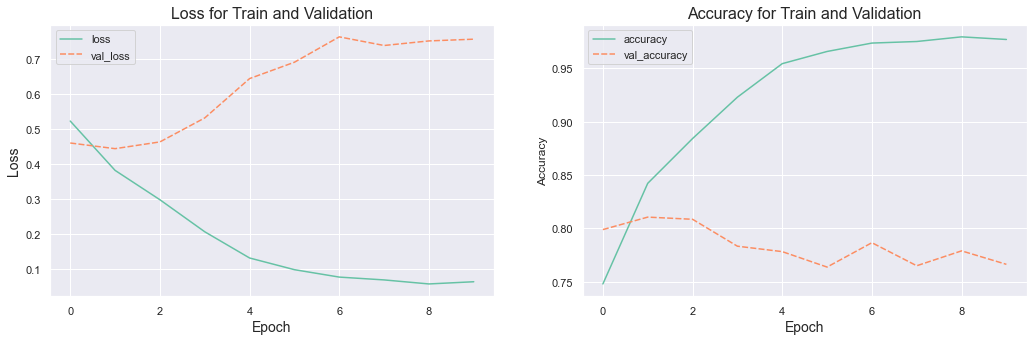

In [108]:
def plot_model_performance(performance):
    performance_loss_df = pd.DataFrame()
    performance_accuracy_df = pd.DataFrame()
    performance_loss_df["loss"] = performance.history['loss']
    performance_loss_df["val_loss"] = performance.history['val_loss']
    performance_accuracy_df["accuracy"] = performance.history['accuracy']
    performance_accuracy_df["val_accuracy"] = performance.history['val_accuracy']
    
    sns.set()
    sns.set_palette(sns.color_palette("Set2"))
    fig, axes = plt.subplots(1, 2, figsize=(17.5, 5))
    sns.lineplot(data = performance_loss_df,  ax = axes[0])
    sns.lineplot(data = performance_accuracy_df, ax = axes[1])
    axes[0].set_xlabel('Epoch',fontsize=14)
    axes[0].set_ylabel('Loss',fontsize=14)
    axes[0].set_title('Loss for Train and Validation', fontsize = 16)
    axes[1].set_xlabel('Epoch',fontsize=14)
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy for Train and Validation', fontsize = 16)
    
plot_model_performance(history)

## Alternate Architecture and Hyper Parameter Tuning

For our first rendition we are going to make 2 changes, first we are going to try an LSTM approach instead of the GRU to see if there are any long sequence patterns we were missing, and second we will add some normilization to the post RNN section of the model. Our normilization efforst will be in the form of a GlobalMaxPool, which will take only the higest cell value at each timestamp. Next the BatchNormalization will normalize each batch in the epoch, helping to create a balanced environment for training the model.

In [109]:
def model_2():
    model = Sequential()
    
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = length_longest_tweet
    ))
    
    model.add(Bidirectional(LSTM(
        length_longest_tweet,
        return_sequences = True,
        recurrent_dropout = 0.2
    )))

    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dense(length_longest_tweet, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

model2 = model_2()
model2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 23, 100)           1670100   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 23, 46)            22816     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 46)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 46)                184       
_________________________________________________________________
dense_26 (Dense)             (None, 23)                1081      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 24        
Total params: 1,694,205
Trainable params: 1,694,113
Non-trainable params: 92
__________________________________________

In [110]:
checkpoint = ModelCheckpoint(
    'model2.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history2 = model2.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32, 
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.7486
Epoch 00001: val_loss improved from inf to 0.52223, saving model to model2.h5
179/179 [==============================] - 6s 35ms/step - loss: 0.5083 - accuracy: 0.7486 - val_loss: 0.5222 - val_accuracy: 0.7836
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8467
Epoch 00002: val_loss improved from 0.52223 to 0.45046, saving model to model2.h5
179/179 [==============================] - 5s 30ms/step - loss: 0.3593 - accuracy: 0.8467 - val_loss: 0.4505 - val_accuracy: 0.7999
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.8902
Epoch 00003: val_loss did not improve from 0.45046
179/179 [==============================] - 6s 33ms/step - loss: 0.2753 - accuracy: 0.8902 - val_loss: 0.4563 - val_accuracy: 0.8025
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9298
Epoch 000

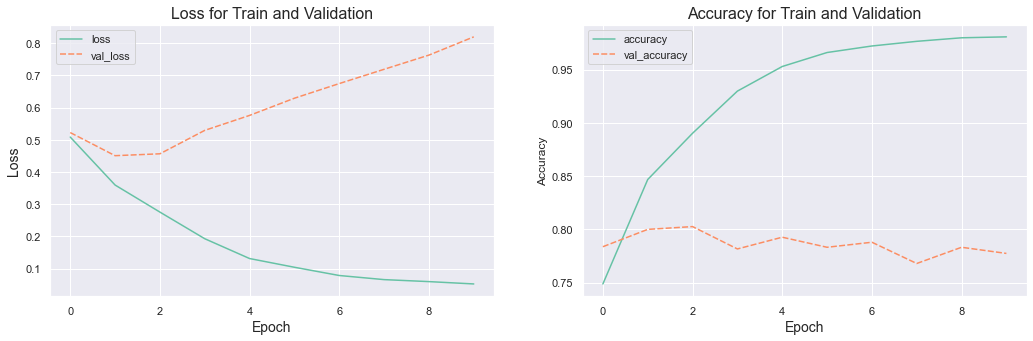

In [111]:
plot_model_performance(history2)

### Alternate Model 2 Review
Our Model continues to be overfit, with little progress being made with our normilzation efforts. Additionally the LSTM vs. GRU appeared to offer no advantage, but increased the training time and resources.

In [112]:
def model_3():
    model = Sequential()
    
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = length_longest_tweet
    ))
    
#    model.add(Bidirectional(LSTM(
#        length_longest_tweet,
#        return_sequences = True,
#        recurrent_dropout = 0.2
#    )))
    
    model.add(Bidirectional(GRU(
        length_longest_tweet,
        return_sequences = True,
        recurrent_dropout = 0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(length_longest_tweet, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

model3 = model_3()
model3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 23, 100)           1670100   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 23, 46)            17250     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 46)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 46)                184       
_________________________________________________________________
dropout_14 (Dropout)         (None, 46)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 23)                1081      
_________________________________________________________________
dropout_15 (Dropout)         (None, 23)              

In [113]:
checkpoint = ModelCheckpoint(
    'model3.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history3 = model3.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32, 
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
177/179 [============================>.] - ETA: 0s - loss: 0.6332 - accuracy: 0.6891
Epoch 00001: val_loss improved from inf to 0.53374, saving model to model3.h5
179/179 [==============================] - 5s 29ms/step - loss: 0.6343 - accuracy: 0.6889 - val_loss: 0.5337 - val_accuracy: 0.7652
Epoch 2/10
178/179 [============================>.] - ETA: 0s - loss: 0.4991 - accuracy: 0.7772
Epoch 00002: val_loss improved from 0.53374 to 0.46107, saving model to model3.h5
179/179 [==============================] - 5s 27ms/step - loss: 0.4984 - accuracy: 0.7777 - val_loss: 0.4611 - val_accuracy: 0.7910
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8026
Epoch 00003: val_loss improved from 0.46107 to 0.45497, saving model to model3.h5
179/179 [==============================] - 5s 27ms/step - loss: 0.4501 - accuracy: 0.8026 - val_loss: 0.4550 - val_accuracy: 0.7988
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.41

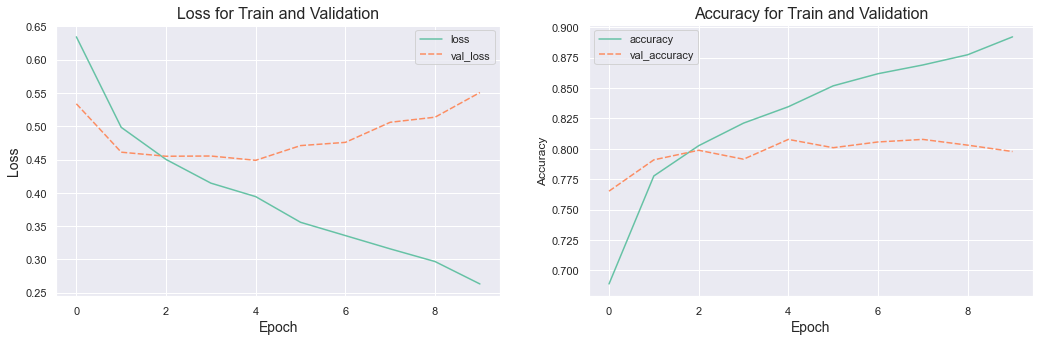

In [114]:
plot_model_performance(history3)

### Alternate Model 3 Review
By adding dropout layers we have started to make inroads on the overfitting issue. While this isn't drastic enough for a truly excellent model, we have found a possible solution moving forward.

Additionally I did some research and I've decided to switch from Adam optimization to RMSprop optimization, which if what I was reading was correct will help with some of the overfitting and improve overall accuracy.

In [115]:
def model_4():
    model = Sequential()
    
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = length_longest_tweet
    ))
    
#    model.add(Bidirectional(LSTM(
#        length_longest_tweet,
#        return_sequences = True,
#        recurrent_dropout = 0.2
#    )))
    
    model.add(Bidirectional(GRU(
        length_longest_tweet,
        return_sequences = True,
        recurrent_dropout = 0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_longest_tweet, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(length_longest_tweet, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

model4 = model_4()
model4.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 23, 100)           1670100   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 23, 46)            17250     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 46)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 46)                184       
_________________________________________________________________
dropout_16 (Dropout)         (None, 46)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 23)                1081      
_________________________________________________________________
dropout_17 (Dropout)         (None, 23)              

In [116]:
checkpoint = ModelCheckpoint(
    'model4.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history4 = model4.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32, 
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.6360
Epoch 00001: val_loss improved from inf to 0.57566, saving model to model4.h5
179/179 [==============================] - 6s 31ms/step - loss: 0.6528 - accuracy: 0.6360 - val_loss: 0.5757 - val_accuracy: 0.7600
Epoch 2/10
178/179 [============================>.] - ETA: 0s - loss: 0.5366 - accuracy: 0.7386
Epoch 00002: val_loss improved from 0.57566 to 0.47795, saving model to model4.h5
179/179 [==============================] - 5s 28ms/step - loss: 0.5369 - accuracy: 0.7388 - val_loss: 0.4779 - val_accuracy: 0.7983
Epoch 3/10
178/179 [============================>.] - ETA: 0s - loss: 0.4824 - accuracy: 0.7804
Epoch 00003: val_loss improved from 0.47795 to 0.44526, saving model to model4.h5
179/179 [==============================] - 5s 27ms/step - loss: 0.4822 - accuracy: 0.7803 - val_loss: 0.4453 - val_accuracy: 0.8051
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.43

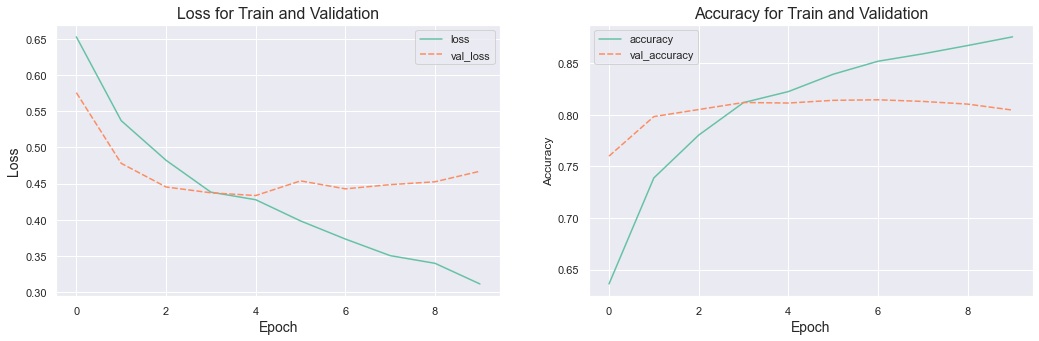

In [117]:
plot_model_performance(history4)

### Alternate Model 4 Review
We increased the dropout rate, which reduced the size of the late epoch backsliding in terms of validation_loss which may indicate that our model is less overfit and more stable over long training periods.

In [118]:
def model_5():
    model = Sequential()
    
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = length_longest_tweet
    ))
    
#    model.add(Bidirectional(LSTM(
#        length_longest_tweet,
#        return_sequences = True,
#        recurrent_dropout = 0.2
#    )))
    
    model.add(Bidirectional(GRU(
        length_longest_tweet,
        return_sequences = True,
        recurrent_dropout = 0.5
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_longest_tweet, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(length_longest_tweet, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

model5 = model_5()
model5.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 23, 100)           1670100   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 23, 46)            17250     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 46)                0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 46)                184       
_________________________________________________________________
dropout_18 (Dropout)         (None, 46)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 23)                1081      
_________________________________________________________________
dropout_19 (Dropout)         (None, 23)              

In [119]:
checkpoint = ModelCheckpoint(
    'model5.h5',
    monitor = 'val_loss',
    verbose = 2,
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history5 = model5.fit(
    X_train,
    y_train,
    epochs = 10,
    batch_size = 32, 
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [checkpoint]
)

Epoch 1/10
177/179 [============================>.] - ETA: 0s - loss: 0.7552 - accuracy: 0.5809
Epoch 00001: val_loss improved from inf to 0.64023, saving model to model5.h5
179/179 [==============================] - 5s 30ms/step - loss: 0.7557 - accuracy: 0.5807 - val_loss: 0.6402 - val_accuracy: 0.7248
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.6781
Epoch 00002: val_loss improved from 0.64023 to 0.50348, saving model to model5.h5
179/179 [==============================] - 5s 26ms/step - loss: 0.6079 - accuracy: 0.6781 - val_loss: 0.5035 - val_accuracy: 0.7826
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7457
Epoch 00003: val_loss improved from 0.50348 to 0.45803, saving model to model5.h5
179/179 [==============================] - 5s 26ms/step - loss: 0.5430 - accuracy: 0.7457 - val_loss: 0.4580 - val_accuracy: 0.7941
Epoch 4/10
177/179 [============================>.] - ETA: 0s - loss: 0.49

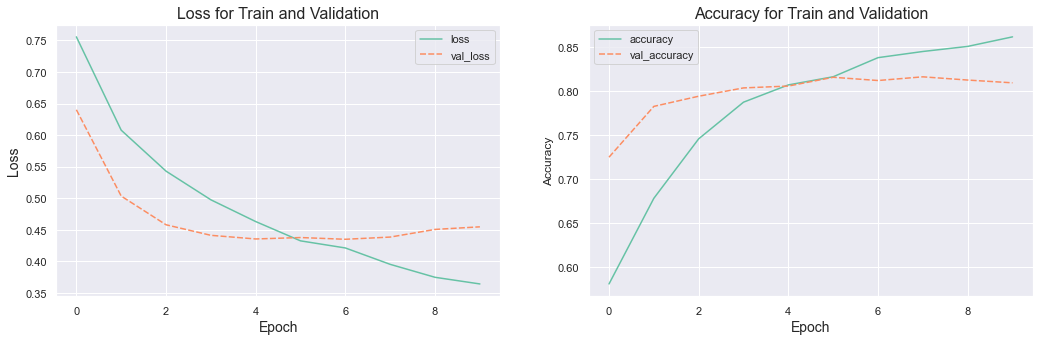

In [120]:
plot_model_performance(history5)

### Alternate Model 5 Review
For our final Model rendition we have added another dense layer in addition to another dropout layer. Additionaly we increased the recurrent_dropout rate from 0.2 to 0.5 in the GRU layer of the model. This model is our most stable by validation loss as a metric, and performed best at epoch 6. We will use the saved state of this model for our final submission.

## Conclusion

Overall RNNs lived up to their reputation of being very difficult to train. While we made some progress by addressing overfitting, there are still some indications that the model is overfit in the later epochs. 

Performance: The final model performed at approximately 81.41% validation accuracy which is a good start, but is underwhelming for a binary classification problem. To help address the performance issue we did alot of data cleaning, but we may want to try a more complex model with a larger data set that does less to remove some of the elements such as punctuation which might reveal some deeper patterns.

Overfitting: The overfitting was our primary issue throughout the entire model architecture process. In future renditions I think a larger dataset in conjunction with more prevelant dropouts may provide a better model. But considering the constraints of the training data size, it will be difficult to make many improvements from where the model currently stands.

Time: I was surprised to find that the models all trained extremely quickly compared to Convolutional nueral network models or even some medium sized dense nueral networks. This may be the case because this is the first model I've trained with Tensorflow instead of Pytorch.

### Submission

In [128]:
submission = pd.read_csv(".\\nlp-getting-started\\sample_submission.csv")
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [139]:
test['text'] = test['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_stop_words(x))
test_tweets = test.text.values
test_tweets = pad_sequences(embed(test_tweets), length_longest_tweet, padding = 'post')
model5.load_weights('model5.h5')
predictions = model5.predict_classes(test_tweets)
submission['target'] = predictions
submission.to_csv('submit.csv', index = False)

<AxesSubplot:xlabel='target', ylabel='count'>

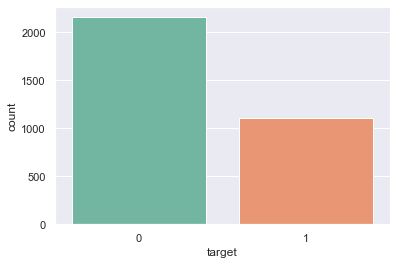

In [140]:
sns.countplot(data = submission, x = 'target')

References:
1. https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#9.-NLP:-Disaster-Tweets
2. https://analyticsindiamag.com/guide-to-tensorflow-keras-optimizers/
3. https://keras.io/api/layers/recurrent_layers/
4. https://www.kaggle.com/code/stuartakeson/nlp-disaster-tweets-with-glove-and-lstm/edit
5. https://analyticsindiamag.com/lstm-vs-gru-in-recurrent-neural-network-a-comparative-study/